Data Loading & Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import random

from sklearn.cluster import Birch
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print("Libraries loaded successfully.")




Libraries loaded successfully.


In [2]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
405460,-0.983139,-0.822600,0.446489,1.000260,-0.938868,-0.726244
47110,0.594867,0.877191,-0.202947,0.115071,0.811260,0.467449
53919,-0.096117,0.049935,-1.031497,-1.357419,0.205446,-0.385189
618056,-1.728401,-1.325862,1.033474,-0.283548,-1.342744,-1.180984
426887,0.041533,0.297816,0.936645,-1.197158,-0.804243,-0.100977


K-Means

Elbow Method

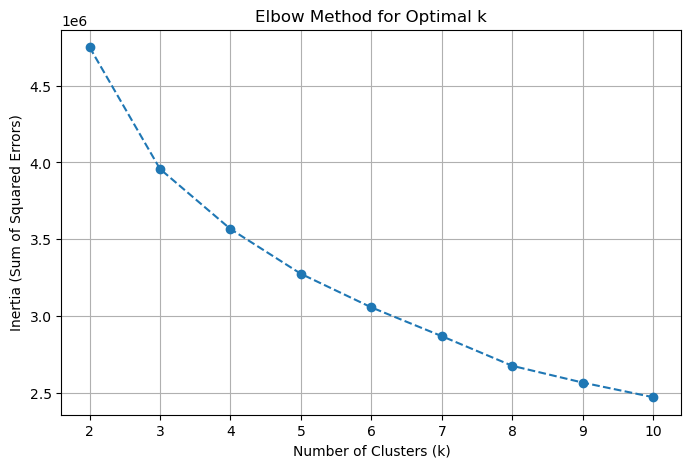

In [3]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [4]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


Application

In [5]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample_scaled.shape[0], k_optimal, replace=False)
centroids = X_sample_scaled[random_indices]

assignments = np.zeros(X_sample_scaled.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample_scaled, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample_scaled, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break

print("Manual Clustering Completed Successfully.")


Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...
Manual Clustering Completed Successfully.


Visualization and analysis

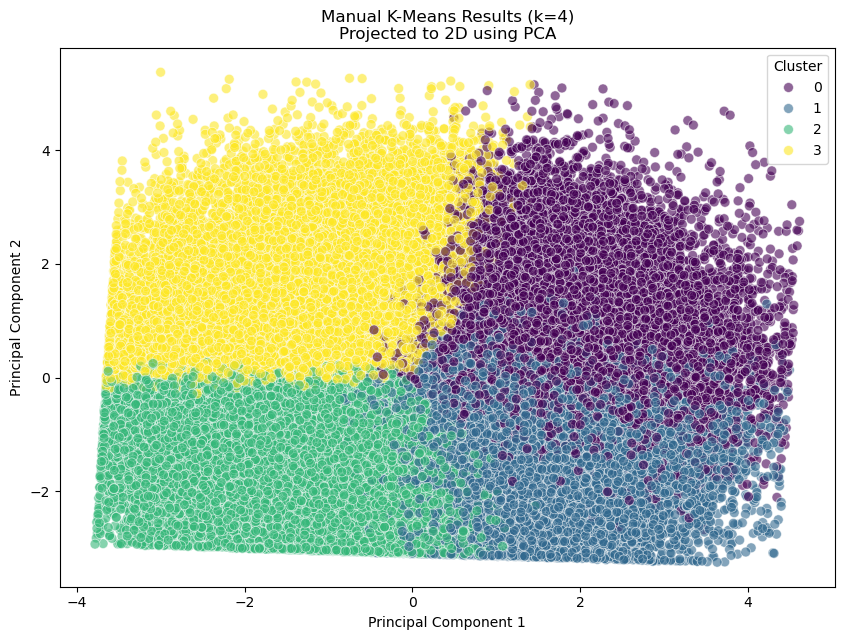


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore
Cluster                                                                    
0        2.241772e+07         6.314467e+07    5.636952            54.526734
1        1.644151e+07         4.578023e+07    7.320797            74.814263
2        1.807725e+06         4.399950e+06    7.753501            79.792645
3        1.678386e+06         4.038149e+06    5.280370            50.335117

Movies per Cluster:
 Cluster  NumMovies
       3      54957
       2      52919
       1      47368
       0      44755


In [6]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))



Model Evaluation

In [7]:
# --- K-MEANS MODEL EVALUATION ---

# 1. Hopkins Statistic (Tendencia al agrupamiento)
# Mide si los datos tienen estructura o son aleatorios.
# > 0.7: Alta tendencia a agruparse (bueno). ~0.5: Datos aleatorios (malo).
def hopkins(X, portion=0.1, seed=247):
    n = X.shape[0]
    d = X.shape[1]
    m = int(portion * n)
    
    if m < 1: return 0.5 # Seguridad para muestras muy pequeñas

    np.random.seed(seed)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    
    # Generar puntos aleatorios en el espacio de datos
    rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m, d))
    
    # Distancia de puntos aleatorios a vecinos reales (u_dist)
    u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
    
    # Distancia de puntos reales a vecinos reales (w_dist)
    idx = np.random.choice(n, size=m, replace=False)
    w_dist = nbrs.kneighbors(X[idx, :], 2, return_distance=True)[0][:, 1]
    
    U = (u_dist**d).sum()
    W = (w_dist**d).sum()
    
    return U / (U + W)

print("\n--- K-Means Evaluation Metrics ---")

# Calcular Hopkins
# Usamos una porción pequeña (0.05) para que sea rápido
h_stat = hopkins(X_sample_scaled, portion=0.05)
print(f"Hopkins Statistic: {h_stat:.4f} (Ideal > 0.7)")

# Calcular Métricas de Validación Interna
# Usamos las etiquetas 'assignments' que generó tu K-Means manual

# Nota de eficiencia: Si X_sample_scaled tiene muchos datos (>10k),
# Silhouette puede ser lento. Hacemos un subsampleo seguro para esta métrica.
if X_sample_scaled.shape[0] > 10000:
    print("Calculando Silhouette con muestra de 10,000 puntos (por eficiencia)...")
    idx_eval = np.random.choice(X_sample_scaled.shape[0], 10000, replace=False)
    X_eval = X_sample_scaled[idx_eval]
    labels_eval = assignments[idx_eval]
else:
    X_eval = X_sample_scaled
    labels_eval = assignments

# 1. Silhouette Score
# Mide cuán similar es un punto a su propio clúster comparado con otros.
# Rango: -1 a 1. (Cuanto más alto, mejor).
sil = silhouette_score(X_eval, labels_eval)
print(f"Silhouette Score: {sil:.4f}")

# 2. Davies-Bouldin Index
# Mide la similitud media entre clústeres.
# (Cuanto más BAJO, mejor separación).
db = davies_bouldin_score(X_sample_scaled, assignments)
print(f"Davies-Bouldin Index: {db:.4f}")

# 3. Calinski-Harabasz Index
# Relación entre la dispersión dentro del clúster y la separación entre clústeres.
# (Cuanto más ALTO, mejor definición).
ch = calinski_harabasz_score(X_sample_scaled, assignments)
print(f"Calinski-Harabasz Index: {ch:.4f}")


--- K-Means Evaluation Metrics ---
Hopkins Statistic: 1.0000 (Ideal > 0.7)
Calculando Silhouette con muestra de 10,000 puntos (por eficiencia)...
Silhouette Score: 0.1575
Davies-Bouldin Index: 1.6624
Calinski-Harabasz Index: 44294.7047


BIRCH

BIRCH HYPERPARAMETER TUNING

Running BIRCH on sample data shape: (199999, 6)

--- Comparing Thresholds ---
Threshold T=0.5 -> Generated 18739 subclusters (11.9965s)
Threshold T=1.0 -> Generated 761 subclusters (5.0046s)
Threshold T=1.5 -> Generated 42 subclusters (2.5944s)
Threshold T=2.0 -> Generated 8 subclusters (2.7618s)
Threshold T=2.5 -> Generated 1 subclusters (2.7465s)


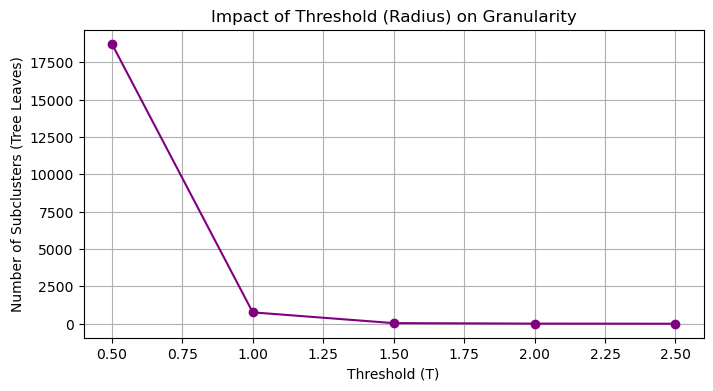

In [8]:
print(f"Running BIRCH on sample data shape: {X_sample_scaled.shape}")

# Parameter to tune: Threshold (T)
# Definition: The radius of the subcluster obtained by merging a new sample.
# (Slide 28: Threshold controls the tree size)
thresholds_to_test = [0.5, 1.0, 1.5, 2.0, 2.5] 
tuning_results = []

print("\n--- Comparing Thresholds ---")

for thresh in thresholds_to_test:
    start_time = time.time()
    
    # n_clusters=None: We let BIRCH generate as many subclusters as the tree needs.
    # This helps us understand the structure before forcing a final k.
    brc = Birch(threshold=thresh, n_clusters=None)
    brc.fit(X_sample_scaled)
    
    elapsed = time.time() - start_time
    num_subclusters = len(brc.subcluster_centers_)
    
    tuning_results.append({
        'Threshold': thresh,
        'Subclusters': num_subclusters,
        'Time_Sec': elapsed
    })
    print(f"Threshold T={thresh} -> Generated {num_subclusters} subclusters ({elapsed:.4f}s)")

# Visualization of the Trade-off
results_df = pd.DataFrame(tuning_results)
plt.figure(figsize=(8, 4))
plt.plot(results_df['Threshold'], results_df['Subclusters'], marker='o', color='purple')
plt.title('Impact of Threshold (Radius) on Granularity')
plt.xlabel('Threshold (T)')
plt.ylabel('Number of Subclusters (Tree Leaves)')
plt.grid(True)
plt.show()

FINAL MODEL AND PROFILING

Training Final BIRCH (T=1.0, k=4)...


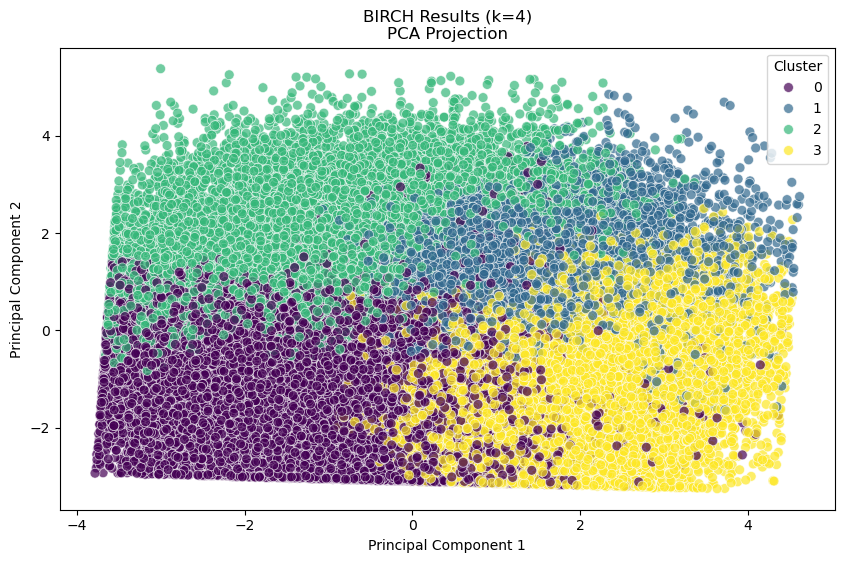


--- Cluster Profiles (Real Values) ---
                  BudgetUSD  Global_BoxOfficeUSD  IMDbRating  \
Cluster_BIRCH                                                  
0              3.205495e+06         8.174970e+06    7.244300   
1              1.464731e+07         4.031683e+07    5.335445   
2              2.269921e+06         5.731000e+06    5.003990   
3              2.478807e+07         7.043712e+07    7.154750   

               RottenTomatoesScore  Movie_Count  
Cluster_BIRCH                                    
0                        73.669824        84682  
1                        51.219801        33130  
2                        46.903692        36591  
3                        72.841631        45596  


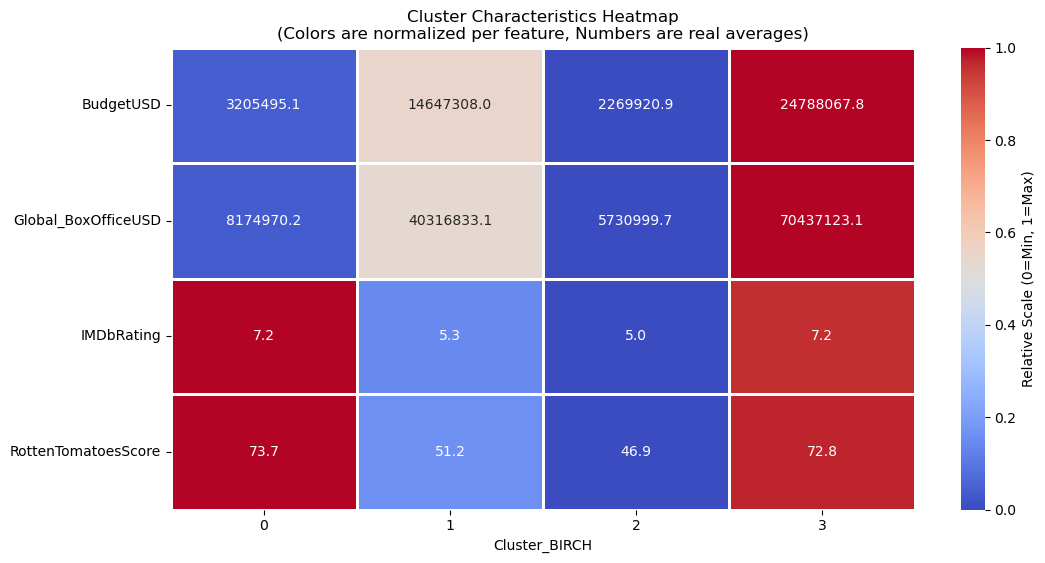

In [9]:
# --- PART 3: FINAL MODEL & PROFILING ---

# Configuration based on analysis (or fixed for the project)
# We use n_clusters=4 to perform the Global Clustering step on the leaves.
final_threshold = 1.0
final_k = 4

print(f"Training Final BIRCH (T={final_threshold}, k={final_k})...")

# 1. Train Model
birch_final = Birch(threshold=final_threshold, n_clusters=final_k)
# We fit on the sample scaled data
labels = birch_final.fit_predict(X_sample_scaled)

# 2. Visualization (PCA 2D Projection)
# Note: Training was done on ALL features. PCA is ONLY for plotting.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
plt.title(f'BIRCH Results (k={final_k})\nPCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 3. Business Profiling
# We map the labels back to the ORIGINAL sample dataframe (df_sample)
# to interpret the Money/Ratings in real values.
df_sample['Cluster_BIRCH'] = labels

numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster_BIRCH')[numeric_cols].mean()
profile['Movie_Count'] = df_sample['Cluster_BIRCH'].value_counts()

print("\n--- Cluster Profiles (Real Values) ---")
print(profile)

# Heatmap for quick interpretation# --- MEJORA DEL HEATMAP ---
# --- HEATMAP MEJORADO (Normalizado) ---
# 1. Normalizamos colores (0-1) para que el dinero no opaque a las notas
scaler_view = MinMaxScaler()
profile_for_plot = profile.drop(columns='Movie_Count')
profile_normalized = pd.DataFrame(
    scaler_view.fit_transform(profile_for_plot),
    columns=profile_for_plot.columns,
    index=profile_for_plot.index
)

# 2. Pintamos el Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    profile_normalized.T,          # Colores normalizados
    annot=profile_for_plot.T,      # Texto con valores REALES
    cmap='coolwarm',
    fmt=".1f",                     # 1 decimal
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Relative Scale (0=Min, 1=Max)'}
)
plt.title("Cluster Characteristics Heatmap\n(Colors are normalized per feature, Numbers are real averages)")
plt.show()

Model evaluation

In [10]:
# --- MODEL EVALUATION ---

# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

# Silhouette Score (adaptado para BIRCH - no hay ruido explícito como en DBSCAN)
def compute_silhouette(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Silhouette: solo hay 1 clúster.")
        return None
    # Usamos una muestra para silhouette si el dataset es muy grande,
    # ya que es computacionalmente costoso (O(N^2))
    if X_scaled.shape[0] > 10000:
        print("Calculando Silhouette con una muestra de 10,000 puntos para eficiencia...")
        indices = np.random.choice(X_scaled.shape[0], 10000, replace=False)
        return silhouette_score(X_scaled[indices], labels[indices])
    return silhouette_score(X_scaled, labels)

# Davies-Bouldin
def compute_davies_bouldin(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Davies-Bouldin: solo hay 1 clúster.")
        return None
    return davies_bouldin_score(X_scaled, labels)

# Calinski-Harabasz
def compute_calinski_harabasz(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Calinski-Harabasz: solo hay 1 clúster.")
        return None
    return calinski_harabasz_score(X_scaled, labels)

# Execution

print("\nBIRCH Evaluation")
print("-----------------------------------")

# Usamos las etiquetas finales del modelo BIRCH (labels) y los datos escalados (X_sample_scaled)

# 1) Hopkins
# Hopkins se calcula sobre los datos antes de clusterizar para ver si vale la pena
H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

# 2) Silhouette
sil = compute_silhouette(X_sample_scaled, labels)
if sil is not None:
    print(f"Silhouette Score: {sil:.4f}")

# 3) Davies-Bouldin
dbi = compute_davies_bouldin(X_sample_scaled, labels)
if dbi is not None:
    print(f"Davies-Bouldin Index: {dbi:.4f}")

# 4) Calinski-Harabasz
chi = compute_calinski_harabasz(X_sample_scaled, labels)
if chi is not None:
    print(f"Calinski-Harabasz Index: {chi:.4f}")


BIRCH Evaluation
-----------------------------------
Hopkins Statistic: 0.99998204
Calculando Silhouette con una muestra de 10,000 puntos para eficiencia...
Silhouette Score: 0.0917
Davies-Bouldin Index: 1.8129
Calinski-Harabasz Index: 31649.4648


DBSCAN

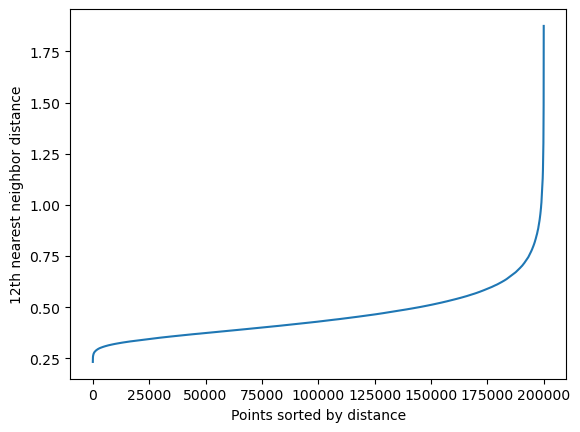

In [9]:
#We plot knn to try to choose an apropriate value for epsilon
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(X_sample_scaled_df)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df)
distances = np.sort(distances[:, 11])
plt.plot(distances)
plt.ylabel("12th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.show()

In [10]:
clusterer = DBSCAN(eps=0.7, min_samples=12, metric='euclidean')
y_pred = clusterer.fit_predict(X_sample_scaled_df)

In [11]:
# Number of clusters and noise
unique_labels = np.unique(y_pred)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(y_pred).count(-1)  # O np.sum(y_pred == -1)

print(f"Número de clústers: {n_clusters}")
print(f"Número de puntos de ruido: {n_noise}")
print(f"Etiquetas únicas de clústers: {unique_labels[unique_labels != -1]}")  # Excluye -1

# We asign clusters in the DataFrame to see the details
df_sample['Cluster'] = y_pred
print("\nTamaños de cada clúster (incluyendo ruido como -1):")
print(df_sample.groupby('Cluster').size())

# Example: first 10 movies in each cluster
for cluster_id in unique_labels:
    if cluster_id != -1:
        print(f"\nClúster {cluster_id}:")
        print(df_sample[df_sample['Cluster'] == cluster_id][['Title', 'Genre', 'IMDbRating']].head(10))

Número de clústers: 1
Número de puntos de ruido: 2955
Etiquetas únicas de clústers: [0]

Tamaños de cada clúster (incluyendo ruido como -1):
Cluster
-1      2955
 0    197044
dtype: int64

Clúster 0:
                         Title    Genre  IMDbRating
377469                 All lot    Drama         5.6
388829                Together    Drama         7.4
206910       Region during pay    Drama         4.6
777196      Authority only new    Drama         3.6
611351        Generation value    Drama         6.1
601597        Life try account  Romance         5.4
861629   Against coach officer    Drama         6.1
129915              Eye artist   Action         5.1
731021    Generation character   Sci-Fi         7.6
983894  Sea tend international    Drama         8.3


DBSCAN - Model Evaluation

In [12]:
# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

# Silhouette Score
def compute_silhouette(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        print("No se puede calcular Silhouette: solo hay 1 clúster válido después de eliminar ruido.")
        return None
    return silhouette_score(X_scaled[mask], labels[mask])

# Davies-Bouldin
def compute_davies_bouldin(X_scaled, labels):
    # Davies-Bouldin requiere al menos 2 clusters reales
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Davies-Bouldin: solo hay 1 clúster.")
        return None
    return davies_bouldin_score(X_scaled, labels)

# Calinski-Harabasz
def compute_calinski_harabasz(X_scaled, labels):
    # Calinski-Harabasz también requiere al menos 2 clusters
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Calinski-Harabasz: solo hay 1 clúster.")
        return None
    return calinski_harabasz_score(X_scaled, labels)

# Execution

print("DBSCAN evaluation")
print("-----------------------------------")

# 1) Hopkins
H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

# 2) Silhouette
sil = compute_silhouette(X_sample_scaled_df.values, y_pred)
print(f"Silhouette Score: {sil}")

# 3) Davies-Bouldin
dbi = compute_davies_bouldin(X_sample_scaled_df.values, y_pred)
print(f"Davies-Bouldin Index: {dbi}")

# 4) Calinski-Harabasz
chi = compute_calinski_harabasz(X_sample_scaled_df.values, y_pred)
print(f"Calinski-Harabasz Index: {chi}")


DBSCAN evaluation
-----------------------------------
Hopkins Statistic: 0.99998243
No se puede calcular Silhouette: solo hay 1 clúster válido después de eliminar ruido.
Silhouette Score: None
Davies-Bouldin Index: 3.853270121445858
Calinski-Harabasz Index: 1296.4508877400906


GAUSSIAN MIXTURE

Running Gaussian Mixture Model on the scaled sample...
cov=full | k=1 | BIC=2730725.0 | AIC=2730449.4
cov=full | k=2 | BIC=2730762.0 | AIC=2730200.6
cov=full | k=3 | BIC=2675219.2 | AIC=2674372.1
cov=full | k=4 | BIC=2425382.9 | AIC=2424250.0
cov=full | k=5 | BIC=2271259.7 | AIC=2269841.1
cov=full | k=6 | BIC=2261801.8 | AIC=2260097.4
cov=full | k=7 | BIC=2258042.6 | AIC=2256052.4
cov=full | k=8 | BIC=2221392.9 | AIC=2219116.9
cov=full | k=9 | BIC=2255317.4 | AIC=2252755.7
cov=full | k=10 | BIC=2253120.7 | AIC=2250273.2
cov=tied | k=1 | BIC=2730725.0 | AIC=2730449.4
cov=tied | k=2 | BIC=2731311.5 | AIC=2730964.5
cov=tied | k=3 | BIC=2731112.4 | AIC=2730694.0
cov=tied | k=4 | BIC=2730778.6 | AIC=2730288.7
cov=tied | k=5 | BIC=2726248.7 | AIC=2725687.4
cov=tied | k=6 | BIC=2726615.7 | AIC=2725982.9
cov=tied | k=7 | BIC=2726970.5 | AIC=2726266.3
cov=tied | k=8 | BIC=2728420.0 | AIC=2727644.3
cov=tied | k=9 | BIC=2725600.4 | AIC=2724753.3
cov=tied | k=10 | BIC=2723397.9 | AIC=2722479.3
cov

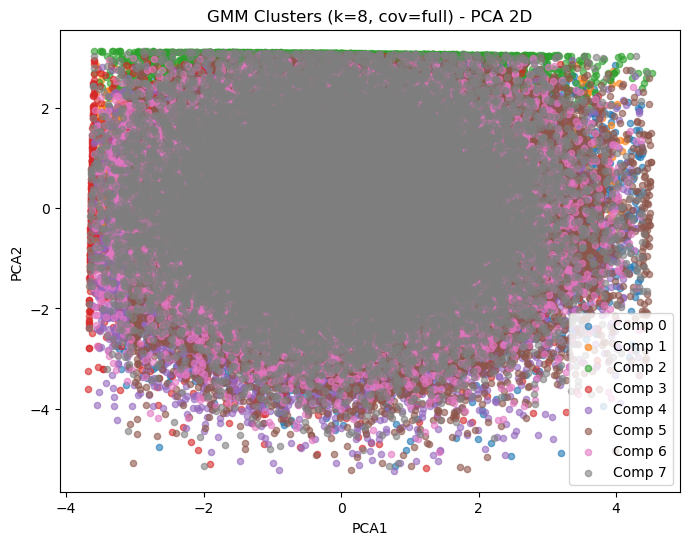


GMM clustering completed successfully.


In [15]:
# === Gaussian Mixture Model (GMM) on X_sample_scaled ===
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set environment variables to avoid BLAS issues
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

print("Running Gaussian Mixture Model on the scaled sample...")

# Range of components to test
n_components_range = range(1, 11)   # adjust if needed
cov_types = ["full", "tied", "diag", "spherical"]

results = []

try:
    for cov in cov_types:
        for k in n_components_range:
            try:
                gm = GaussianMixture(
                    n_components=k,
                    covariance_type=cov,
                    random_state=42,
                    n_init=3,  # Reduced from 5 to speed up
                    max_iter=100
                )
                gm.fit(X_sample_scaled)
                bic = gm.bic(X_sample_scaled)
                aic = gm.aic(X_sample_scaled)
                results.append({
                    "covariance": cov,
                    "k": k,
                    "bic": bic,
                    "aic": aic,
                    "model": gm
                })
                print(f"cov={cov} | k={k} | BIC={bic:.1f} | AIC={aic:.1f}")
            except Exception as e:
                print(f"Skipping cov={cov}, k={k}: {str(e)[:50]}")
                continue
except Exception as e:
    print(f"Error during GMM training: {e}")

# Convert to DataFrame for analysis
if len(results) > 0:
    gmm_results_df = pd.DataFrame(results)
    
    # Select best model (lowest BIC)
    best_row = gmm_results_df.loc[gmm_results_df["bic"].idxmin()]
    best_model = best_row["model"]
    best_cov = best_row["covariance"]
    best_k = int(best_row["k"])
    
    print("\n=== BEST GMM MODEL ===")
    print(f"Covariance type: {best_cov}")
    print(f"Number of components: {best_k}")
    
    # Predict hard and soft cluster assignments
    gmm_labels = best_model.predict(X_sample_scaled)
    gmm_probs = best_model.predict_proba(X_sample_scaled)
    
    df_sample["GMM_Label"] = gmm_labels
    df_sample["GMM_MaxProb"] = gmm_probs.max(axis=1)
    
    print("\nCluster counts:")
    print(df_sample["GMM_Label"].value_counts())
    
    # Optional: add per-cluster probability columns
    for c in range(best_k):
        df_sample[f"GMM_Prob_{c}"] = gmm_probs[:, c]
    
    # Silhouette score (only if >1 cluster)
    if best_k > 1:
        sil = silhouette_score(X_sample_scaled, gmm_labels)
        print(f"\nSilhouette score: {sil:.4f}")
    
    # ---------- Visualization using PCA 2D ----------
    pca_gmm = PCA(n_components=2)
    X_gmm_2d = pca_gmm.fit_transform(X_sample_scaled)
    
    plt.figure(figsize=(8,6))
    for c in range(best_k):
        mask = (gmm_labels == c)
        plt.scatter(X_gmm_2d[mask, 0], X_gmm_2d[mask, 1], s=20, alpha=0.6, label=f"Comp {c}")
    
    plt.title(f"GMM Clusters (k={best_k}, cov={best_cov}) - PCA 2D")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()
    
    print("\nGMM clustering completed successfully.")
else:
    print("No valid GMM models were trained. Check your environment setup.")

## GMM Cluster Profiling and Comparison

=== GMM CLUSTER PROFILES ===

              BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore  \
GMM_Label                                                                       
0          9.474128e+06         3.014844e+07    6.521105            64.930883   
1          8.226035e+06         1.339715e+07    7.073054            73.011560   
2          1.003939e+07         2.865142e+07    9.218843           100.000000   
3          9.740387e+06         9.741003e+06    6.447765            64.141896   
4          1.119484e+07         2.245912e+07    5.973468            57.517651   
5          9.853109e+06         4.340716e+07    6.394381            63.516102   
6          9.553952e+06         2.231427e+07    6.402077            63.792832   
7          9.908939e+06         2.740490e+07    6.486720            64.757178   

           Movie_Count  
GMM_Label               
0                37299  
1                18166  
2                 4617  
3                19169  
4        

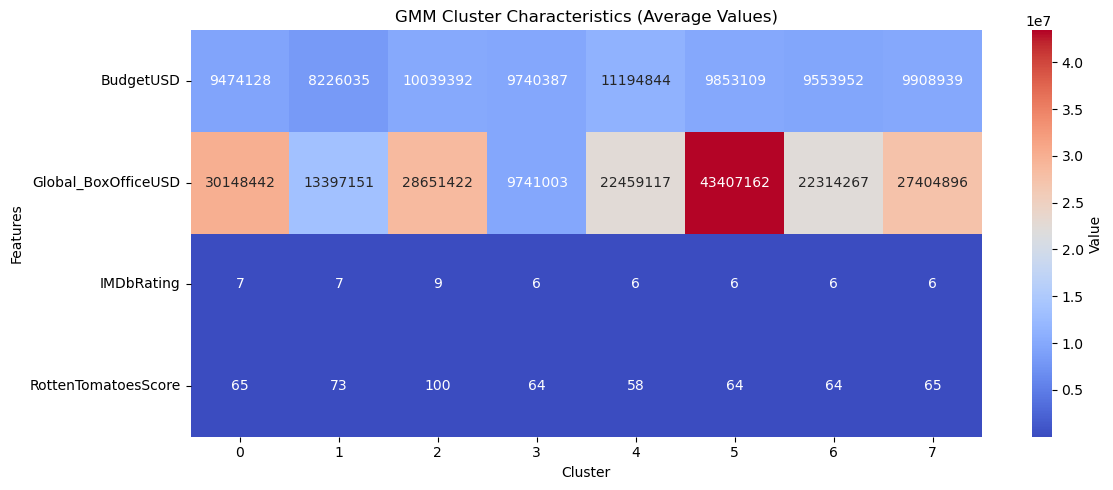

In [18]:
# === GMM CLUSTER PROFILING ===
print("=== GMM CLUSTER PROFILES ===\n")

numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
gmm_profile = df_sample.groupby('GMM_Label')[numeric_cols].mean()
gmm_profile['Movie_Count'] = df_sample['GMM_Label'].value_counts().sort_index()

print(gmm_profile)
print("\n")

# Heatmap for visualization
plt.figure(figsize=(12, 5))
sns.heatmap(gmm_profile.drop(columns='Movie_Count').T, cmap='coolwarm', annot=True, fmt=".0f", cbar_kws={'label': 'Value'})
plt.title("GMM Cluster Characteristics (Average Values)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## Comparison of All Clustering Methods

CLUSTERING METHODS COMPARISON SUMMARY

1. CLUSTER DISTRIBUTION:
----------------------------------------------------------------------

K-Means Cluster Sizes:
Cluster
-1      2955
 0    197044
Name: count, dtype: int64

BIRCH Cluster Sizes:
Cluster_BIRCH
0    59233
1    67094
2    46603
3    27069
Name: count, dtype: int64

GMM Cluster Sizes:
GMM_Label
0    37299
1    18166
2     4617
3    19169
4    30084
5    44745
6    20843
7    25076
Name: count, dtype: int64


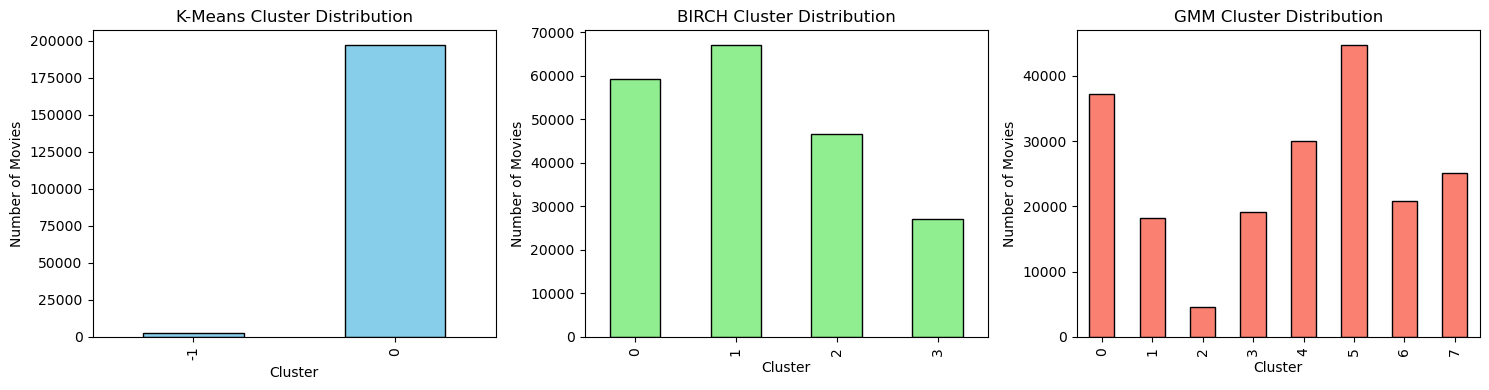


2. KEY INSIGHTS:
----------------------------------------------------------------------
K-Means: 2 clusters (manual k=4)
BIRCH: 4 clusters (threshold=1.5, k=4)
GMM: 8 components (best BIC: cov=full, k=8)

GMM Silhouette Score: -0.0395
GMM Average Confidence (max probability): 0.7900

ANALYSIS COMPLETE!


In [19]:
# === COMPARISON: ALL CLUSTERING METHODS ===
print("=" * 70)
print("CLUSTERING METHODS COMPARISON SUMMARY")
print("=" * 70)

# 1. Cluster Distribution
print("\n1. CLUSTER DISTRIBUTION:")
print("-" * 70)
print("\nK-Means Cluster Sizes:")
print(df_sample['Cluster'].value_counts().sort_index())
print("\nBIRCH Cluster Sizes:")
print(df_sample['Cluster_BIRCH'].value_counts().sort_index())
print("\nGMM Cluster Sizes:")
print(df_sample['GMM_Label'].value_counts().sort_index())

# 2. Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df_sample['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('K-Means Cluster Distribution')
axes[0].set_ylabel('Number of Movies')
axes[0].set_xlabel('Cluster')

df_sample['Cluster_BIRCH'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('BIRCH Cluster Distribution')
axes[1].set_ylabel('Number of Movies')
axes[1].set_xlabel('Cluster')

df_sample['GMM_Label'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='salmon', edgecolor='black')
axes[2].set_title('GMM Cluster Distribution')
axes[2].set_ylabel('Number of Movies')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# 3. Key insights
print("\n2. KEY INSIGHTS:")
print("-" * 70)
print(f"K-Means: {df_sample['Cluster'].nunique()} clusters (manual k=4)")
print(f"BIRCH: {df_sample['Cluster_BIRCH'].nunique()} clusters (threshold=1.5, k=4)")
print(f"GMM: {df_sample['GMM_Label'].nunique()} components (best BIC: cov={best_cov}, k={best_k})")
print(f"\nGMM Silhouette Score: {sil:.4f}")
print(f"GMM Average Confidence (max probability): {df_sample['GMM_MaxProb'].mean():.4f}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)
